## Triplets Dataset Creation

In [1]:
!wget http://cs.stanford.edu/people/ranjaykrishna/vrd/json_dataset.zip

--2019-11-30 17:35:54--  http://cs.stanford.edu/people/ranjaykrishna/vrd/json_dataset.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/ranjaykrishna/vrd/json_dataset.zip [following]
--2019-11-30 17:35:54--  https://cs.stanford.edu/people/ranjaykrishna/vrd/json_dataset.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 638638 (624K) [application/zip]
Saving to: ‘json_dataset.zip’

json_dataset.zip    100%[===================>] 623.67K  1.78MB/s    in 0.3s    

2019-11-30 17:35:55 (1.78 MB/s) - ‘json_dataset.zip’ saved [638638/638638]



In [2]:
!unzip json_dataset.zip

Archive:  json_dataset.zip
  inflating: annotations_test.json   
  inflating: annotations_train.json  
  inflating: objects.json            
  inflating: predicates.json         
  inflating: readme.txt              


In [0]:
!mkdir triplets_dataset

In [0]:
#If positive example is (man, next to, bus)
#The negative example will be like (man, leaning on, bus)

import json
import imageio

def createTripletExamples(predicate, filename):

  
  f = open("objects.json", 'r')
  objList = json.load(f)

  f = open("predicates.json", 'r')
  predList = json.load(f)

  #From here on you don't need to change anything
  if(filename=="annotations_test.json"):
      newFilename = str("triplets_dataset/"+predicate+'_test_triplets.json')
  else:
      newFilename = str("triplets_dataset/"+predicate + '_train_triplets.json')

  data = {'predicate': predicate, 'examples': []}
  def addToData(filename1, filename2, p_bbox1, p_bbox2, n_bbox1, n_bbox2, p_name1, p_name2, n_name1, n_name2, relationship_p, relationship_n):
      row = {}
      row['filename1'] = filename1
      row['filename2'] = filename2

      row['positive'] = {}
      row['negative'] = {}

      row['positive']['bbox1'] = p_bbox1
      row['positive']['bbox2'] = p_bbox2
      row['positive']['obj1'] = p_name1
      row['positive']['obj2'] = p_name2
      row['positive']['relationship'] = relationship_p

      row['negative']['bbox1'] = n_bbox1
      row['negative']['bbox2'] = n_bbox2
      row['negative']['obj1'] = n_name1
      row['negative']['obj2'] = n_name2
      row['negative']['relationship'] = relationship_n

      data['examples'].append(row)


  def getDistance(bb1, bb2):
      bb1_x1 = bb1['x']
      bb1_y1 = bb1['y']
      bb1_w = bb1['w']
      bb1_h = bb1['h']
      bb1_x2 = bb1_x1+bb1_w
      bb1_y2 = bb1_y1+bb1_h

      bb2_x1 = bb2['x']
      bb2_y1 = bb2['y']
      bb2_w = bb2['w']
      bb2_h = bb2['h']
      bb2_x2 = bb2_x1 + bb2_w
      bb2_y2 = bb2_y1 + bb2_h

      dx = min(bb1_x1-bb2_x1, bb1_x1-bb2_x2, bb1_x2-bb2_x1, bb1_x2-bb2_x2)
      dy = min(bb1_y1 - bb2_y1, bb1_y1 - bb2_y2, bb1_y2 - bb2_y1, bb1_y2 - bb2_y2)
      return dx**2 + dy**2

  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  existing_tuple_dict = {}

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)

          #Iterate over all images
          k_cnt = 0
          for key in datastore.keys():
            k_cnt += 1
            filename = key

            relationships = datastore[key]
            #iterate over all relationships
            for it in range(0, len(relationships)):
              p_relationship = relationships[it]
              
              p_predicate_id = p_relationship["predicate"]
              p_object_tuple = p_relationship["object"]
              p_subject_tuple = p_relationship["subject"]

              p_object_id = p_object_tuple["category"]
              p_object_bb = p_object_tuple["bbox"]

              p_subject_id = p_subject_tuple["category"]
              p_subject_bb = p_subject_tuple["bbox"]

              p_objname1 = objList[p_object_id]
              p_objname2 = objList[p_subject_id]
              p_predname = predList[p_predicate_id]

              if p_object_id in existing_tuple_dict.keys():
                if existing_tuple_dict[p_object_id] == p_subject_id:
                  continue
              
              existing_tuple_dict[p_object_id] = p_subject_id


              if p_predname != predicate:
                continue

              # addToData(filename, filename, p_object_bb, p_subject_bb, p_object_bb, p_subject_bb, p_objname1, p_objname2,p_objname1, p_objname2, p_predname, p_predname)
              k2_cnt = 0
              flag = 1
              for key2 in datastore.keys():
                if flag == 0:
                  break
                filename2 = key2
                k2_cnt += 1
                if k2_cnt <= k_cnt:
                  continue
                relationships2 = datastore[key2]
                for it2 in range(it+1, len(relationships2)):
                  n_relationship = relationships2[it2]
                
                  n_predicate_id = n_relationship["predicate"]
                  n_object_tuple = n_relationship["object"]
                  n_subject_tuple = n_relationship["subject"]

                  n_object_id = n_object_tuple["category"]
                  n_object_bb = n_object_tuple["bbox"]

                  n_subject_id = n_subject_tuple["category"]
                  n_subject_bb = n_subject_tuple["bbox"]

                  n_objname1 = objList[n_object_id]
                  n_objname2 = objList[n_subject_id]
                  n_predname = predList[n_predicate_id]  

                  if p_predicate_id != n_predicate_id and p_object_id == n_object_id and p_subject_id == n_subject_id:
                    addToData(filename, filename2, p_object_bb, p_subject_bb, n_object_bb, n_subject_bb, p_objname1, p_objname2,n_objname1, n_objname2, p_predname, n_predname)
                    flag = 0
                    break



          # for it in range(len(datastore)):
          #     for i in range(len(datastore[it]['relationships'])):
          #         row = datastore[it]['relationships'][i]
          #         if(row['relationship']==predicate):
          #             obj1 = row['objects'][0]
          #             obj2 = row['objects'][1]
          #             p_bb1 = datastore[it]['objects'][obj1]['bbox']
          #             p_bb2 = datastore[it]['objects'][obj2]['bbox']
          #             p_objname1 = datastore[it]['objects'][obj1]['names'][0]
          #             p_objname2 = datastore[it]['objects'][obj2]['names'][0]

          #             for it2 in range(it+1, len(datastore)):
          #                 nearest2obj1 = -1
          #                 dist_obj1 = -1
          #                 nearest2obj2 = -1
          #                 dist_obj2 = -1
          #                 for j in range(len(datastore[it2]['relationships'])):
          #                     row = datastore[it2]['relationships'][j]
          #                     if(datastore[it2]['objects'][row['objects'][0]]['names'][0]==datastore[it]['objects'][obj1]['names'][0]
          #                             and datastore[it2]['objects'][row['objects'][1]]['names'][0]==datastore[it]['objects'][obj2]['names'][0]
          #                             and row['relationship']!=predicate):
          #                         n_bb1 = datastore[it2]['objects'][row['objects'][0]]['bbox']
          #                         n_bb2 = datastore[it2]['objects'][row['objects'][1]]['bbox']
          #                         n_objname1 = datastore[it2]['objects'][row['objects'][0]]['names'][0]
          #                         n_objname2 = datastore[it2]['objects'][row['objects'][1]]['names'][0]
          #                         addToData(datastore[it]['filename'], datastore[it2]['filename'], p_bb1, p_bb2, n_bb1, n_bb2, p_objname1, p_objname2,n_objname1, n_objname2, predicate, row['relationship'])
          #                     elif(datastore[it2]['objects'][row['objects'][0]]['names'][0]==datastore[it]['objects'][obj2]['names'][0]
          #                             and datastore[it2]['objects'][row['objects'][1]]['names'][0]==datastore[it]['objects'][obj1]['names'][0]
          #                             and row['relationship']!=predicate):
          #                         n_bb1 = datastore[it2]['objects'][row['objects'][1]]['bbox']
          #                         n_bb2 = datastore[it2]['objects'][row['objects'][0]]['bbox']
          #                         n_objname1 = datastore[it2]['objects'][row['objects'][1]]['names'][0]
          #                         n_objname2 = datastore[it2]['objects'][row['objects'][0]]['names'][0]
          #                         addToData(datastore[it]['filename'], datastore[it2]['filename'], p_bb1, p_bb2, n_bb1, n_bb2, p_objname1, p_objname2,n_objname1, n_objname2, predicate, row['relationship'])

  with open(newFilename, 'w') as f:
      json.dump(data, f)


In [5]:
#Just change this based on the file and predicate used
# predicate = 'behind'
filename = "annotations_train.json"

# createTripletExamples(predicate, filename)

predicates = ["on", "wear", "has", "next to", "sleep next to", "sit next to", "stand next to", "park next", "walk next to", "above", "behind", "stand behind", "sit behind", "park behind", "in the front of", "under", "stand under", "sit under", "near", "walk to", "walk", "walk past", "in", "below", "beside", "walk beside", "over", "hold", "by", "beneath", "with", "on the top of", "on the left of", "on the right of", "sit on", "ride", "carry", "look", "stand on", "use", "at", "attach to", "cover", "touch", "watch", "against", "inside", "adjacent to", "across", "contain", "drive", "drive on", "taller than", "eat", "park on", "lying on", "pull", "talk", "lean on", "fly", "face", "play with", "sleep on", "outside of", "rest on", "follow", "hit", "feed", "kick", "skate on"]
cnt = 0
for predicate in predicates:
  createTripletExamples(predicate, filename)
  print(str(cnt+1),": ",predicate," done.")
  cnt += 1

1 :  on  done.
2 :  wear  done.
3 :  has  done.
4 :  next to  done.
5 :  sleep next to  done.
6 :  sit next to  done.
7 :  stand next to  done.
8 :  park next  done.
9 :  walk next to  done.
10 :  above  done.
11 :  behind  done.
12 :  stand behind  done.
13 :  sit behind  done.
14 :  park behind  done.
15 :  in the front of  done.
16 :  under  done.
17 :  stand under  done.
18 :  sit under  done.
19 :  near  done.
20 :  walk to  done.
21 :  walk  done.
22 :  walk past  done.
23 :  in  done.
24 :  below  done.
25 :  beside  done.
26 :  walk beside  done.
27 :  over  done.
28 :  hold  done.
29 :  by  done.
30 :  beneath  done.
31 :  with  done.
32 :  on the top of  done.
33 :  on the left of  done.
34 :  on the right of  done.
35 :  sit on  done.
36 :  ride  done.
37 :  carry  done.
38 :  look  done.
39 :  stand on  done.
40 :  use  done.
41 :  at  done.
42 :  attach to  done.
43 :  cover  done.
44 :  touch  done.
45 :  watch  done.
46 :  against  done.
47 :  inside  done.
48 :  adjacen

In [6]:
!wget http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip

--2019-11-30 17:36:40--  http://imagenet.stanford.edu/internal/jcjohns/scene_graphs/sg_dataset.zip
Resolving imagenet.stanford.edu (imagenet.stanford.edu)... 171.64.68.16
Connecting to imagenet.stanford.edu (imagenet.stanford.edu)|171.64.68.16|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2000609775 (1.9G) [application/zip]
Saving to: ‘sg_dataset.zip’

sg_dataset.zip      100%[===================>]   1.86G  5.46MB/s    in 4m 49s  

2019-11-30 17:41:29 (6.60 MB/s) - ‘sg_dataset.zip’ saved [2000609775/2000609775]



In [7]:
!unzip sg_dataset.zip

Archive:  sg_dataset.zip
   creating: sg_dataset/
  inflating: sg_dataset/sg_test_annotations.json  
   creating: sg_dataset/sg_test_images/
  inflating: sg_dataset/sg_test_images/10002158834_6dd6c6667f_b.jpg  
  inflating: sg_dataset/sg_test_images/10003466765_d20a7655c6_b.jpg  
  inflating: sg_dataset/sg_test_images/10008170616_a54deca9e3_b.jpg  
  inflating: sg_dataset/sg_test_images/10050248663_2cdb49c115_b.jpg  
  inflating: sg_dataset/sg_test_images/1006083276_0c1a4345fb_o.jpg  
  inflating: sg_dataset/sg_test_images/10085008474_8d72a9dc5e_b.jpg  
  inflating: sg_dataset/sg_test_images/10104268563_965a646010_b.jpg  
  inflating: sg_dataset/sg_test_images/10132007626_6421a783be_b.jpg  
  inflating: sg_dataset/sg_test_images/10132084253_cfa22219a1_b.jpg  
  inflating: sg_dataset/sg_test_images/10142659205_1158853119_b.jpg  
  inflating: sg_dataset/sg_test_images/10142737776_a40de33ab1_b.jpg  
  inflating: sg_dataset/sg_test_images/10161340284_8a72090a5b_b.jpg  
  inflating: sg_data

## Triplets Dataset Visualization

In [0]:
import imageio
import matplotlib.pyplot as plt
import numpy as np


def visualizeDataset(filename, numExamples=10):

  #No need to make changes from here
  def getCoordinates(bbox):
      # x = bbox['x']
      # y = bbox['y']
      # w = bbox['w']
      # h = bbox['h']

      # x2 = x+w
      # y2 = y+h

      y = bbox[0]
      y2 = bbox[1]
      
      x = bbox[2]
      x2 = bbox[3]

      x_coordinates = np.array([x,x,x2,x2,x])
      y_coordinates = np.array([y,y2,y2,y,y])
      return x_coordinates, y_coordinates

  import json
  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          print("Total Positive Negative Example Pairs for this predicate = ",len(datastore['examples']))
          for it in range(min(len(datastore['examples']),numExamples)):
              filename1 = datastore['examples'][it]['filename1']
              filename2 = datastore['examples'][it]['filename2']

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']
              n_bb1 = datastore['examples'][it]['negative']['bbox1']
              n_bb2 = datastore['examples'][it]['negative']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']
              n_obj1 = datastore['examples'][it]['negative']['obj1']
              n_obj2 = datastore['examples'][it]['negative']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']
              n_pred = datastore['examples'][it]['negative']['relationship']

              img1 = imageio.imread("sg_dataset/sg_train_images/"+filename1)
              img2 = imageio.imread("sg_dataset/sg_train_images/"+filename2)


              plt.subplot(121)
              plt.title("Positive Example: \n"+p_obj1+", "+p_pred+", "+p_obj2)
              plt.imshow(img1)
              coordinates_x, coordinates_y = getCoordinates(p_bb1)
              plt.plot(coordinates_x, coordinates_y, 'b-')
              coordinates_x, coordinates_y = getCoordinates(p_bb2)
              plt.plot(coordinates_x, coordinates_y, 'b-')

              plt.subplot(122)
              plt.title("Negative Example: \n" + n_obj1 + ", " + n_pred + ", " + n_obj2)
              plt.imshow(img2)
              coordinates_x, coordinates_y = getCoordinates(n_bb1)
              plt.plot(coordinates_x, coordinates_y, 'r-')
              coordinates_x, coordinates_y = getCoordinates(n_bb2)
              plt.plot(coordinates_x, coordinates_y, 'r-')
              plt.show()

Total Positive Negative Example Pairs for this predicate =  2569


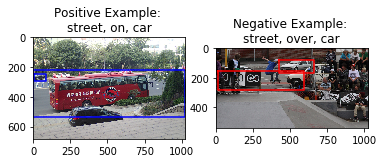

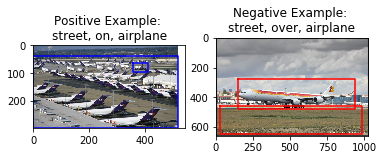

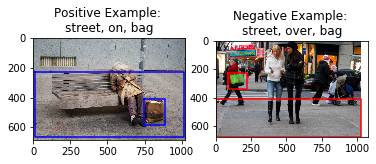

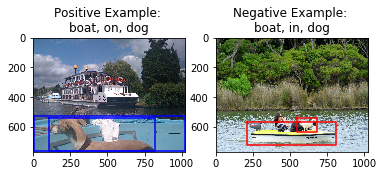

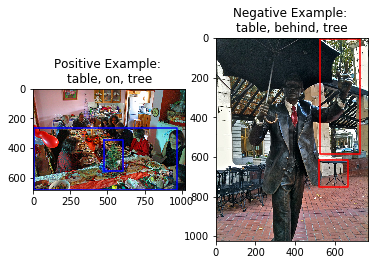

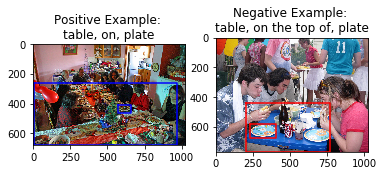

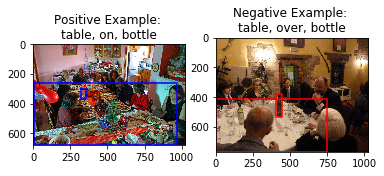

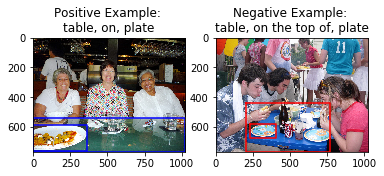

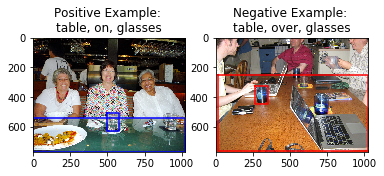

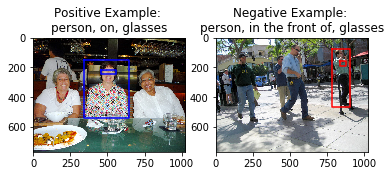

In [10]:
#Just enter filename
filename = "triplets_dataset/on_train_triplets.json"

visualizeDataset(filename)

## Bounding Boxes etc. Dataset Generation

In [11]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip

--2019-11-28 12:46:39--  http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/wordvecs/glove.6B.zip [following]
--2019-11-28 12:46:39--  https://nlp.stanford.edu/data/wordvecs/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip [following]
--2019-11-28 12:46:39--  http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182753 (822M) [applic

In [12]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       
  inflating: glove.6B.50d.txt        


In [13]:
!pip install bcolz

     |████████████████████████████████| 1.5MB 4.9MB/s 
  Created wheel for bcolz: filename=bcolz-1.2.1-cp36-cp36m-linux_x86_64.whl size=2656546 sha256=d471bbeab00eab69676922c95c757a450560342c0e6aa85949adf2a7d0a871a3
  Stored in directory: /root/.cache/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz


In [14]:
import bcolz
import numpy as np
import pickle

words = []
idx = 0
word2idx = {}
vectors = bcolz.carray(np.zeros(1), rootdir=f'6B.50.dat', mode='w')

with open(f'glove.6B.50d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        vectors.append(vect)
    
print(vectors.shape)
vectors = bcolz.carray(vectors[1:].reshape((400001, 50)), rootdir=f'6B.50.dat', mode='w')
vectors.flush()
pickle.dump(words, open(f'6B.50_words.pkl', 'wb'))
pickle.dump(word2idx, open(f'6B.50_idx.pkl', 'wb'))

(20000051,)


In [0]:
vectors = bcolz.open(f'6B.50.dat')[:]
words = pickle.load(open(f'6B.50_words.pkl', 'rb'))
word2idx = pickle.load(open(f'6B.50_idx.pkl', 'rb'))

glove = {w: vectors[word2idx[w]] for w in words}

In [16]:
keys = glove.keys()
# print(keys)
print(glove['tree'])
print(glove['behind'])
print(glove['woman'])
# print(glove['taller than'])
print(glove['price'])
print(glove['cost'])

def dist(obj1, obj2):
  d = np.sum((obj1-obj2)**2)
  return d

print(dist(glove['price'], glove['cost']))
print(dist(glove['price'], glove['money']))
print(dist(glove['price'], glove['tree']))

# sample_dict = {'1': 1, '2': 2, '3': 3}
# print(sample_dict.keys())

[ 0.62231   1.1986   -0.014116  0.20125   0.69419   0.12068  -0.90399
 -1.4023    0.43357  -0.48537  -0.4645    0.15756   0.54261  -0.32467
 -0.025646  0.45742   0.16561   0.18819   0.062099 -0.86418  -1.0425
 -0.81157   0.3126   -0.20279   0.55734  -0.28634  -0.14874   1.0098
  0.25041  -0.53195   2.3793   -0.76966  -0.63219   0.3203    0.15072
  0.23326  -0.26254  -0.29461   0.7671   -0.11577  -0.68129  -0.65413
 -0.58914   0.24684   1.5904    0.33025   0.41513  -1.7468    0.82453
 -1.0886  ]
[ 1.4300e-01  2.6092e-01  7.6382e-01  3.5628e-01  9.1959e-01  4.9457e-01
 -7.6588e-01  6.4717e-02 -3.3686e-01 -2.8793e-01 -4.5472e-01 -5.8281e-01
 -1.6087e+00  4.1016e-01  1.7273e-01 -1.7497e-01  4.4972e-01 -5.0394e-01
 -7.2187e-01 -6.9418e-01 -4.1760e-01  4.4668e-01 -1.7090e-01  1.9292e-02
  2.2104e-01 -1.5443e+00  5.2365e-02  3.3870e-01  3.0423e-01 -3.4121e-01
  2.6934e+00  3.3241e-01 -7.9032e-02 -1.8409e-01 -6.3973e-02  6.4029e-02
 -3.3883e-01  5.4885e-01 -6.7208e-03 -4.6441e-01 -1.1413e-01  

In [0]:


inputBBImageList = []
inputSubImageList = []
inputObjImageList = []
inputSubVectorList = []
inputObjVectorList = []
outputPredictionsList = []

# add_cnt = 0

def add(item, desc):
  if(desc=="bbimg"):
    inputBBImageList.append(item)
  elif(desc=="subimg"):
    inputSubImageList.append(item)
  elif(desc=="objimg"):
    inputObjImageList.append(item)
  elif(desc=="subvec"):
    inputSubVectorList.append(item)
  elif(desc=="objvec"):
    inputObjVectorList.append(item)
  else:
    outputPredictionsList.append(item)

1
Total Positive Negative Example Pairs for this predicate =  4191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:299: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:305: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:198: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future versi

1000  examples chosen
2
Total Positive Negative Example Pairs for this predicate =  460
460  examples chosen
3
Total Positive Negative Example Pairs for this predicate =  883
878  examples chosen
4
Total Positive Negative Example Pairs for this predicate =  1654


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12348030976 bytes but only got 0. Skipping tag 278
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


1000  examples chosen
5
Total Positive Negative Example Pairs for this predicate =  1
1  examples chosen
6
Total Positive Negative Example Pairs for this predicate =  33
33  examples chosen
7
Total Positive Negative Example Pairs for this predicate =  33
33  examples chosen
8
Total Positive Negative Example Pairs for this predicate =  15
15  examples chosen
9
Total Positive Negative Example Pairs for this predicate =  0
0  examples chosen
10
Total Positive Negative Example Pairs for this predicate =  1797
1000  examples chosen
11
Total Positive Negative Example Pairs for this predicate =  1692
1000  examples chosen
12
Total Positive Negative Example Pairs for this predicate =  4
4  examples chosen
13
Total Positive Negative Example Pairs for this predicate =  2
2  examples chosen
14
Total Positive Negative Example Pairs for this predicate =  1
1  examples chosen
15
Total Positive Negative Example Pairs for this predicate =  1224
1000  examples chosen
16
Total Positive Negative Example 

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4278190080 bytes but only got 0. Skipping tag 256
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2097152 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2162688 bytes but only got 0. Skipping tag 5
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to

1000  examples chosen
17
Total Positive Negative Example Pairs for this predicate =  1
1  examples chosen
18
Total Positive Negative Example Pairs for this predicate =  1
1  examples chosen
19
Total Positive Negative Example Pairs for this predicate =  880
866  examples chosen
20
Total Positive Negative Example Pairs for this predicate =  7
6  examples chosen
21
Total Positive Negative Example Pairs for this predicate =  2
2  examples chosen
22
Total Positive Negative Example Pairs for this predicate =  3
3  examples chosen
23
Total Positive Negative Example Pairs for this predicate =  414
411  examples chosen
24
Total Positive Negative Example Pairs for this predicate =  588


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3932160 bytes but only got 0. Skipping tag 49
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 6468665344 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12386304 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 12058624 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting

578  examples chosen
25
Total Positive Negative Example Pairs for this predicate =  500
483  examples chosen
26
Total Positive Negative Example Pairs for this predicate =  1
1  examples chosen
27
Total Positive Negative Example Pairs for this predicate =  377


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 10485760 bytes but only got 0. Skipping tag 55
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 15335424 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 14024704 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 126877996 bytes but only got 0. Skipping tag 4352
  " Skipping tag %s" % (size, len(data), tag))


368  examples chosen
28
Total Positive Negative Example Pairs for this predicate =  185
185  examples chosen
29
Total Positive Negative Example Pairs for this predicate =  301
300  examples chosen
30
Total Positive Negative Example Pairs for this predicate =  197
197  examples chosen
31
Total Positive Negative Example Pairs for this predicate =  57
57  examples chosen
32
Total Positive Negative Example Pairs for this predicate =  102
102  examples chosen
33
Total Positive Negative Example Pairs for this predicate =  247
244  examples chosen
34
Total Positive Negative Example Pairs for this predicate =  219
214  examples chosen
35
Total Positive Negative Example Pairs for this predicate =  84
84  examples chosen
36
Total Positive Negative Example Pairs for this predicate =  37
37  examples chosen
37
Total Positive Negative Example Pairs for this predicate =  64
64  examples chosen
38
Total Positive Negative Example Pairs for this predicate =  47
47  examples chosen
39
Total Positive Neg

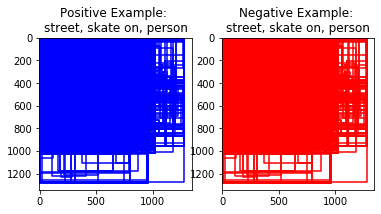

In [54]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import json
from matplotlib import cm
from PIL import Image

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
  

def channelWise(bbox, target_dim=100):
  if(bbox.shape[0]<bbox.shape[1]):
    multiplier = target_dim/bbox.shape[1]
    new_dim_0 = int(bbox.shape[0]*multiplier)
    new_dim_1 = target_dim
    new_dim_0 = np.maximum(new_dim_0, 1)
    new_dim_1 = np.maximum(new_dim_1, 1)
    bbox = Image.fromarray(bbox)
    bbox = bbox.resize((new_dim_1, new_dim_0), Image.ANTIALIAS)

    new_bbox = np.zeros(shape=[target_dim, target_dim])
    margin = (target_dim-new_dim_0)//2
    new_bbox[margin:margin+new_dim_0,:] = bbox
  else:
    multiplier = target_dim/bbox.shape[0]
    new_dim_1 = int(bbox.shape[1]*multiplier)
    new_dim_0 = target_dim
    new_dim_0 = np.maximum(new_dim_0, 1)
    new_dim_1 = np.maximum(new_dim_1, 1)
    bbox = Image.fromarray(bbox)
    bbox = bbox.resize((new_dim_1, new_dim_0), Image.ANTIALIAS)

    new_bbox = np.zeros(shape=[target_dim, target_dim])
    margin = (target_dim-new_dim_1)//2
    new_bbox[:,margin:margin+new_dim_1] = bbox
  return np.array(new_bbox)

def getBBoxImage(bbox, target_dim=100):
  # bbox = rgb2gray(bbox)
  nb0 = channelWise(bbox[:,:,0], target_dim)
  nb1 = channelWise(bbox[:,:,1], target_dim)
  nb2 = channelWise(bbox[:,:,2], target_dim)

  newBox = np.zeros(shape=[nb0.shape[0], nb0.shape[1], 3])
  newBox[:,:,0] = nb0
  newBox[:,:,1] = nb1
  newBox[:,:,2] = nb2
  return newBox

# def visualizeDataset(filename, numExamples=10):

filename = "triplets_dataset/behind_test_triplets.json"
predicates = ["on", "wear", "has", "next to", "sleep next to", "sit next to", "stand next to", "park next", "walk next to", "above", "behind", "stand behind", "sit behind", "park behind", "in the front of", "under", "stand under", "sit under", "near", "walk to", "walk", "walk past", "in", "below", "beside", "walk beside", "over", "hold", "by", "beneath", "with", "on the top of", "on the left of", "on the right of", "sit on", "ride", "carry", "look", "stand on", "use", "at", "attach to", "cover", "touch", "watch", "against", "inside", "adjacent to", "across", "contain", "drive", "drive on", "taller than", "eat", "park on", "lying on", "pull", "talk", "lean on", "fly", "face", "play with", "sleep on", "outside of", "rest on", "follow", "hit", "feed", "kick", "skate on"]
p_cnt = 0

for predicate in predicates:
  pred_ex_cnt = 0
  p_cnt += 1
  # if(p_cnt==3):
    # break
  # if(p_cnt>10):
    # continue
  # if p_cnt <= 3:
    # continue
  # if p_cnt > 15:
    # break
  # if p_cnt <= 30:
  #   continue
  # if p_cnt > 45:
  #   break
  print(p_cnt)
  # if p_cnt > 10:
    # break
  filename = "triplets_dataset/"+predicate+"_train_triplets.json"
  # numExamples = 1000

  


  #No need to make changes from here
  def getCoordinates(bbox):
      # x = bbox['x']
      # y = bbox['y']
      # w = bbox['w']
      # h = bbox['h']

      # x2 = x+w
      # y2 = y+h

      y = bbox[0]
      y2 = bbox[1]
      x = bbox[2]
      x2 = bbox[3]

      x_coordinates = np.array([x,x,x2,x2,x])
      y_coordinates = np.array([y,y2,y2,y,y])
      return x_coordinates, y_coordinates

  import json
  filter = "JSON file (*.json)|*.json|All Files (*.*)|*.*||"

  def rgb2gray(rgb):
      return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])  

  #Read JSON data into the datastore variable
  if filename:
      with open(filename, 'r') as f:
          datastore = json.load(f)
          print("Total Positive Negative Example Pairs for this predicate = ",len(datastore['examples']))
          index_cnt = 0
          for it in range(0,len(datastore['examples'])):
              if(pred_ex_cnt==1000):
                break
              filename1 = datastore['examples'][it]['filename1']
              filename2 = datastore['examples'][it]['filename2']

              if filename1 == "4392556686_44d71ff5a0_o.jpg":
                filename1 = "4392556686_44d71ff5a0_o.gif"
              if filename2 == "4392556686_44d71ff5a0_o.jpg":
                filename2 = "4392556686_44d71ff5a0_o.gif"

              p_bb1 = datastore['examples'][it]['positive']['bbox1']
              p_bb2 = datastore['examples'][it]['positive']['bbox2']
              n_bb1 = datastore['examples'][it]['negative']['bbox1']
              n_bb2 = datastore['examples'][it]['negative']['bbox2']

              p_obj1 = datastore['examples'][it]['positive']['obj1']
              p_obj2 = datastore['examples'][it]['positive']['obj2']
              n_obj1 = datastore['examples'][it]['negative']['obj1']
              n_obj2 = datastore['examples'][it]['negative']['obj2']

              p_pred = datastore['examples'][it]['positive']['relationship']
              n_pred = datastore['examples'][it]['negative']['relationship']

              # if(p_pred.find(" ")!=-1):
              #   p_pred = p_pred[:p_pred.find(" ")]
              # if(n_pred.find(" ")!=-1):
              #   n_pred = n_pred[:n_pred.find(" ")]
              # if(p_obj1.find(" ")!=-1):
              #   p_obj1 = p_obj1[:p_obj1.find(" ")]
              # if(n_obj1.find(" ")!=-1):
              #   n_obj1 = n_obj1[:n_obj1.find(" ")]
              # if(p_obj2.find(" ")!=-1):
              #   p_obj2 = p_obj2[:p_obj2.find(" ")]
              # if(n_obj2.find(" ")!=-1):
              #   n_obj2 = n_obj2[:n_obj2.find(" ")]

              # if p_pred not in glove:
              #   continue
              # if n_pred not in glove:
              #   continue
              if p_obj1 not in glove:
                continue
              if n_obj1 not in glove:
                continue
              if p_obj2 not in glove:
                continue
              if n_obj2 not in glove:
                continue

              # print(p_obj1," ",p_pred," ",p_obj2)
              # print(glove[p_obj1]," ",glove[p_pred]," ",glove[p_obj2])
              # print(n_obj1," ",n_pred," ",n_obj2)
              # print(glove[n_obj1]," ",glove[n_pred]," ",glove[n_obj2])
              
              vector1 = np.zeros(shape=[150])
              vector1[:50] = glove[p_obj1]
              # vector1[50:100] = glove[p_pred]
              vector1[50:100] = glove[p_obj2]



              # vector2 = np.zeros(shape=[150])
              # vector2[:50] = glove[n_obj1]
              # vector2[50:100] = glove[n_pred]
              # vector2[100:] = glove[n_obj2]

              # add(vector2[:50], desc="subvec")
              # add(vector2[100:], desc="objvec")
              

              # outputPredictions[index_cnt, 0] = 1
              # outputPredictions[index_cnt+1, 0] = 0

              # img1 = Image.open("sg_dataset/sg_test_images/"+filename1)
              # img2 = Image.open("sg_dataset/sg_test_images/"+filename2)
              img1 = imageio.imread("sg_dataset/sg_train_images/"+filename1)
              img2 = imageio.imread("sg_dataset/sg_train_images/"+filename2)
              img_o1 = np.array(img1)
              img_o2 = np.array(img2)
              img1 = np.array(img1)
              img2 = np.array(img2)
              img1 = img1*0.0
              img2 = img2*0.0
              

              plt.subplot(121)
              plt.title("Positive Example: \n"+p_obj1+", "+p_pred+", "+p_obj2)

              # plt.imshow(img1)
              coordinates_x, coordinates_y = getCoordinates(p_bb1)
              coordinates_x = np.array(coordinates_x, np.int32)
              coordinates_y = np.array(coordinates_y, np.int32)
              # img1_bbox1 = img_o1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])]
              dx = np.maximum(np.min(coordinates_y),0)-np.minimum(np.max(coordinates_y),img1.shape[0])
              dy = np.maximum(np.min(coordinates_x),0)-np.minimum(np.max(coordinates_x),img1.shape[1])
              # print(dx," ",dy)
              if dx==0 or dy==0:
                print("con0")
                continue
              img1_bbox1 = getBBoxImage(img_o1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])], 50)
              img1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])] = 0.5
              # plt.plot(coordinates_x, coordinates_y, 'b-')
              coordinates_x, coordinates_y = getCoordinates(p_bb2)
              coordinates_x = np.array(coordinates_x, np.int32)
              coordinates_y = np.array(coordinates_y, np.int32)
              dx = np.maximum(np.min(coordinates_y),0)-np.minimum(np.max(coordinates_y),img1.shape[0])
              dy = np.maximum(np.min(coordinates_x),0)-np.minimum(np.max(coordinates_x),img1.shape[1])
              # print(dx," ",dy)
              if dx==0 or dy==0:
                print("con1")
                continue
              
              # img1_bbox2 = img_o1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])]
              img1_bbox2 = getBBoxImage(img_o1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])], 50)
              
              img1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])] += 1.0
              img1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])] /= 2.0
              img1[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img1.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img1.shape[1])] /= 0.75
              # plt.plot(coordinates_x, coordinates_y, 'b-')
              # img1 = np.resize(img1, new_shape=[100,100,3])
              new_width  = 50
              new_height = 50
              img1 = rgb2gray(img1)
              img1 = np.array((img1 * 255).astype(np.uint8))
              img1 = Image.fromarray(img1)
              img1 = img1.resize((new_width, new_height), Image.ANTIALIAS)
              # inputImages[index_cnt,:,:,0] = np.array(img1)
              plt.imshow(img1)

              plt.subplot(122)
              plt.title("Negative Example: \n" + n_obj1 + ", " + n_pred + ", " + n_obj2)
              # plt.imshow(img2)
              coordinates_x, coordinates_y = getCoordinates(n_bb1)
              coordinates_x = np.array(coordinates_x, np.int32)
              coordinates_y = np.array(coordinates_y, np.int32)
              # print(coordinates_x," ",coordinates_y)
              # img2_bbox1 = img_o2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])]
              img2_bbox1 = getBBoxImage(img_o2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])], 50)
              
              img2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])] = 0.5
              # plt.plot(coordinates_x, coordinates_y, 'r-')
              coordinates_x, coordinates_y = getCoordinates(n_bb2)
              coordinates_x = np.array(coordinates_x, np.int32)
              coordinates_y = np.array(coordinates_y, np.int32)
              # print(coordinates_x," ",coordinates_y)
              # img2_bbox2 = img_o2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])]
              img2_bbox2 = getBBoxImage(img_o2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])], 50)
              
              img2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])] += 1.0
              img2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])] /= 2.0
              img2[np.maximum(np.min(coordinates_y),0):np.minimum(np.max(coordinates_y),img2.shape[0]), np.maximum(np.min(coordinates_x),0):np.minimum(np.max(coordinates_x),img2.shape[1])] /= 0.75
              # plt.plot(coordinates_x, coordinates_y, 'r-')
              # img2 = np.resize(img2, new_shape=[100,100,3])
              img2 = rgb2gray(img2)
              img2 = np.array((img2 * 255).astype(np.uint8))
              img2 = Image.fromarray(img2)
              img2 = img2.resize((new_width, new_height), Image.ANTIALIAS)
              # inputImages[index_cnt+1,:,:,0] = np.array(img2)
              if np.max(img1) == 0 or np.max(img2) == 0:
                print("con2")
                continue
              add(np.array(img1), desc="bbimg")
              # add(np.array(img2), desc="bbimg")

              # img1_bbox1 = Image.fromarray(img1_bbox1)
              # img1_bbox1 = img1_bbox1.resize((new_width, new_height), Image.ANTIALIAS)

              # img1_bbox2 = Image.fromarray(img1_bbox2)
              # img1_bbox2 = img1_bbox2.resize((new_width, new_height), Image.ANTIALIAS)

              # img2_bbox1 = Image.fromarray(img2_bbox1)
              # img2_bbox1 = img2_bbox1.resize((new_width, new_height), Image.ANTIALIAS)

              # img2_bbox2 = Image.fromarray(img2_bbox2)
              # img2_bbox2 = img2_bbox2.resize((new_width, new_height), Image.ANTIALIAS)

              add(np.array(img1_bbox1), desc="subimg")
              add(np.array(img1_bbox2), desc="objimg")
              # add(np.array(img2_bbox1), desc="subimg")
              # add(np.array(img2_bbox2), desc="objimg")



              plt.imshow(img2)
              # plt.show()

              plt.subplot(121)
              # plt.imshow(img_o1)
              coordinates_x, coordinates_y = getCoordinates(p_bb1)
              plt.plot(coordinates_x, coordinates_y, 'b-')
              coordinates_x, coordinates_y = getCoordinates(p_bb2)
              # plt.plot(coordinates_x, coordinates_y, 'b-')
              plt.subplot(122)
              # plt.imshow(img_o2)
              coordinates_x, coordinates_y = getCoordinates(n_bb1)
              plt.plot(coordinates_x, coordinates_y, 'r-')
              coordinates_x, coordinates_y = getCoordinates(n_bb2)
              # plt.plot(coordinates_x, coordinates_y, 'r-')
              # plt.show()

              add(p_pred, desc="output")
              # add(n_pred, desc="output")

              add(vector1[:50], desc="subvec")
              add(vector1[50:100], desc="objvec")
              
              

              index_cnt += 1
              pred_ex_cnt += 1
  print(pred_ex_cnt," examples chosen")

In [0]:
# inputBBImageList = []
# inputSubImageList = []
# inputObjImageList = []
# inputSubVectorList = []
# inputObjVectorList = []
# outputPredictionsList = []

predicates = ["on", "wear", "has", "next to", "sleep next to", "sit next to", "stand next to", "park next", "walk next to", "above", "behind", "stand behind", "sit behind", "park behind", "in the front of", "under", "stand under", "sit under", "near", "walk to", "walk", "walk past", "in", "below", "beside", "walk beside", "over", "hold", "by", "beneath", "with", "on the top of", "on the left of", "on the right of", "sit on", "ride", "carry", "look", "stand on", "use", "at", "attach to", "cover", "touch", "watch", "against", "inside", "adjacent to", "across", "contain", "drive", "drive on", "taller than", "eat", "park on", "lying on", "pull", "talk", "lean on", "fly", "face", "play with", "sleep on", "outside of", "rest on", "follow", "hit", "feed", "kick", "skate on"]
pred_dict = {}

pred_id = 0
for predicate in predicates:
  pred_dict[predicate] = pred_id
  pred_id += 1

def getPredId(predicate):
  return pred_dict[predicate]

def getAll():
  total_cnt = len(inputBBImageList)
  
  inputImg = np.zeros(shape=[total_cnt, 50, 50, 1])
  inputSubImg = np.zeros(shape=[total_cnt, 50, 50, 3])
  inputObjImg = np.zeros(shape=[total_cnt, 50, 50, 3])
  inputSubVector = np.zeros(shape=[total_cnt, 50])
  inputObjVector = np.zeros(shape=[total_cnt, 50])
  outputPredictions = np.zeros(shape=[total_cnt, 1])
  
  for i in range(total_cnt):
    inputImg[i,:,:,0] = inputBBImageList[i]
    inputSubImg[i] = inputSubImageList[i]
    inputObjImg[i] = inputObjImageList[i]
    inputSubVector[i] = inputSubVectorList[i]
    inputObjVector[i] = inputObjVectorList[i]
    outputPredictions[i] = pred_dict[outputPredictionsList[i]]
  
  return inputImg, inputSubImg, inputObjImg, inputSubVector, inputObjVector, outputPredictions

inputImages, inputSubImages, inputObjImages, inputSubVectors, inputObjVectors, outputPredictions = getAll()
np.save("balancedInputImages.npy", inputImages)
np.save("balancedInputSubImages.npy", inputSubImages)
np.save("balancedInputObjImages.npy", inputObjImages)
np.save("balancedInputSubVectors.npy", inputSubVectors)
np.save("balancedInputObjVectors.npy", inputObjVectors)
np.save("balancedOutputPredictions.npy", outputPredictions)

In [56]:
print(index_cnt)
print(len(inputBBImageList))

print(inputImages.shape)
print(inputSubImages.shape)
print(inputObjImages.shape)
print(inputSubVectors.shape)
print(inputObjVectors.shape)
print(outputPredictions.shape)

1
12128
(12128, 50, 50, 1)
(12128, 50, 50, 3)
(12128, 50, 50, 3)
(12128, 50)
(12128, 50)
(12128, 1)


In [60]:
!zip -r newestV2_balanced_dataset.zip newestV2_balanced_dataset/

  adding: newestV2_balanced_dataset/ (stored 0%)
  adding: newestV2_balanced_dataset/balancedInputSubImages.npy (deflated 90%)
  adding: newestV2_balanced_dataset/balancedOutputPredictions.npy (deflated 100%)
  adding: newestV2_balanced_dataset/balancedInputObjImages.npy (deflated 90%)
  adding: newestV2_balanced_dataset/balancedInputObjVectors.npy (deflated 84%)
  adding: newestV2_balanced_dataset/balancedInputSubVectors.npy (deflated 84%)
  adding: newestV2_balanced_dataset/balancedInputImages.npy (deflated 98%)


## Upload Dataset to Drive

In [0]:
# filenames = ['smallerUpdatedData1to15.zip', 'smallerUpdatedData30to45.zip']
filenames = ['newestV2_balanced_dataset.zip']

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials



# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
ids = []

for i in range(len(filenames)):
  uploaded = drive.CreateFile({'MyTitle': 'Sample-upload.txt'})
  uploaded.SetContentFile(filenames[i])
  uploaded.Upload()
  ids.append(uploaded.get('id'))

In [0]:
def ids2link(ids):
  return "https://drive.google.com/open?id="+ids


In [65]:
links = [ids2link(id) for id in ids]
print(links)
print(filenames)

['https://drive.google.com/open?id=1A87QsBGGnzf8LHeFsUwW41XicXTzFkAR']
['newestV2_balanced_dataset.zip']


## Model using Bounding Box and Word Vectors as Input to predict the likelihood of the Predicate being present in the image

In [0]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD





# Generate dummy data
# x_train = np.random.random((100, 100, 100, 3))
x_train_img = np.array(inputImages)/255.0
x_train_words = np.array(inputSPOVectors)
y_train = keras.utils.to_categorical(outputPredictions, num_classes=2)
# x_test = np.random.random((20, 100, 100, 3))
# y_test = keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)


from keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten
from keras.models import Model

# First, define the vision modules
inputImage = Input(shape=(100, 100, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputImage)
z = keras.layers.add([x, inputImage])
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
z = Dropout(0.1)(z)
x = MaxPooling2D((2, 2))(z)

y = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
z = keras.layers.add([x, y])
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
z = Dropout(0.1)(z)
x = MaxPooling2D((2, 2))(z)

y = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
z = keras.layers.add([x, y])
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
z = Dropout(0.1)(z)
x = MaxPooling2D((2, 2))(z)

x = Flatten()(x)

inputWords = Input(shape=(150,))

concatenated = keras.layers.concatenate([x, inputWords])

y = Dense(128, activation='relu')(concatenated)

out = Dense(2, activation='softmax')(y)

model = Model([inputImage, inputWords], out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

indices = np.arange(0, x_train_img.shape[0])

x_total_img_shuffled = x_train_img[indices]
x_total_words_shuffled = x_train_words[indices]
y_total_shuffled = y_train[indices]

test_split = int(0.1 * x_total_img_shuffled.shape[0])

x_test_img = x_total_img_shuffled[-test_split:]
x_test_words = x_total_words_shuffled[-test_split:]
y_test = y_total_shuffled[-test_split:]


x_train_img = x_total_img_shuffled[:test_split]
x_train_words = x_total_words_shuffled[:test_split]
y_train = y_total_shuffled[:test_split]

# indices = np.arange(0, x_train_img.shape[0])
# np.random.shuffle(indices)


model.fit([x_train_img, x_train_words], [y_train],
          epochs=100, batch_size=64, shuffle=True, validation_split=0.1)

performance = model.evaluate(x=[x_test_img, x_test_words], y=[y_test], batch_size=64)
print(performance)

## Qualitative Evaluation

In [0]:
%load_ext autoreload
%autoreload 2
import torchvision
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model2.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(original_name=FrozenBatchNorm2d)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
       

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [0]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path) # Load the image
  transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model2([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class

In [0]:
import numpy as np
def object_detection_api(img_path, sub, obj, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  print("here")
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  
  sub_list=[]
  obj_list=[]

  for i in range(len(boxes)):
    print(pred_cls[i])
    if(pred_cls[i]==sub):
      sub_list.append(i)
    if(pred_cls[i]==obj):
      obj_list.append(i)

  imgList = []
  # print(sub_list)
  # print(obj_list)

  for i1 in range(len(sub_list)):
    for j1 in range(len(obj_list)):
      print(i1," ",j1)
      if(sub_list[i1]==obj_list[j1]):
        continue
      plt.clf()
      img1 = np.array(img)
      img2 = np.array(img)
      img1 = img1*0.0
      i = sub_list[i1]
      # print(boxes[i])
      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img_bbox = np.zeros(shape=[8], dtype=np.int32)
      img_bbox[0] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[1] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[2] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[3] = int(max(boxes[i][0][0], boxes[i][1][0]))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] = 0.5
      
      i = obj_list[j1]
      # print(boxes[i])
      img_bbox[4] = int(min(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[5] = int(max(boxes[i][0][1], boxes[i][1][1]))
      img_bbox[6] = int(min(boxes[i][0][0], boxes[i][1][0]))
      img_bbox[7] = int(max(boxes[i][0][0], boxes[i][1][0]))

      imgList.append(img_bbox)

      # print(int(min(boxes[i][1]))," ",int(max(boxes[i][1]))," : ",int(min(boxes[i][0]))," ",int(max(boxes[i][0])))
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] += 1.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 2.0
      img1[int(min(boxes[i][0][1], boxes[i][1][1])):int(max(boxes[i][0][1], boxes[i][1][1])), int(min(boxes[i][0][0], boxes[i][1][0])):int(max(boxes[i][0][0], boxes[i][1][0]))] /= 0.75
      # plt.subplot(121)
      # plt.imshow(img1)
      

      i = sub_list[i1]
      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class

      

      
      i = obj_list[j1]

      cv2.rectangle(img2, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
      cv2.putText(img2,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
      # plt.subplot(122)
      # plt.imshow(img2)
      # plt.show()
  
  final_img_bbox = np.zeros(shape=[len(imgList),8], dtype=np.int32)
  for i in range(len(imgList)):
    final_img_bbox[i,:] = imgList[i]
  return final_img_bbox

      

In [0]:
# filename = "sg_dataset/sg_train_images/10007531244_0f2c46cf70_b.jpg"
# subject = "cup"
# predicate = "near"
# obj = "person"

# filename = "sg_dataset/sg_train_images/1589782798_1412fcabd5_o.jpg"
# subject = "person"
# predicate = "under"
# obj = "umbrella"

filename = "sg_dataset/sg_train_images/2637269067_618d25375b_o.jpg"
subject = "banana"
predicate = "next"
obj = "bottle"


sub_vec = glove[subject]
pred_vec = glove[predicate]
obj_vec = glove[obj]


img = imageio.imread(filename)



word_vec = np.zeros(shape=[1,150])
word_vec[:,:50] = sub_vec
word_vec[:,50:100] = pred_vec
word_vec[:,100:] = obj_vec

bboxes = object_detection_api(filename, subject, obj)

for i in range(bboxes.shape[0]):
  img1 = np.array(img)
  img1 = img1*0.0

  img1[bboxes[i,0]:bboxes[i,1], bboxes[i,2]:bboxes[i,3]] = 0.5    
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] += 1.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 2.0
  img1[bboxes[i,4]:bboxes[i,5], bboxes[i,6]:bboxes[i,7]] /= 0.75
  img1 = rgb2gray(img1)
  img1 = np.array((img1 * 255).astype(np.uint8))
  img1 = Image.fromarray(img1)
  img1 = img1.resize((100, 100), Image.ANTIALIAS)

  img1 = np.array(img1)
  img1 = img1/255.0
  
  plt.imshow(img1)
  plt.show()

  img1 = np.reshape(img1, newshape=[1,img1.shape[0],img1.shape[1],1])

  y_pred = model.predict(x=[img1, word_vec])
  print(y_pred)
  

In [0]:
# model.evaluate(x=[x_test_img, x_test_words], y=[y_test], batch_size=64)
y_pred = model.predict(x=[test_img, test_words])